In [2]:
import pandas as pd
import pyensembl
import numpy as np
from types import MappingProxyType

In [3]:
mut_file=open("/home/ls/rachelcw/projects/salmon/transcriptome_mut.fa","r")
unmut_file=open("/home/ls/rachelcw/projects/salmon/transcriptome_unmut.fa","r")
head_seq_dict={}
for line in unmut_file:
    line=line.strip()
    if line.startswith(">"):
        head=line
    else: # line = seq
        if head not in head_seq_dict.keys():
            head_seq_dict[head]=line
for line in mut_file:
    line=line.strip()
    head=''
    if line not in head_seq_dict.keys():
        if line.startswith(">"):
            head=line
        else: # line = seq
            head_seq_dict[head]=line
mut_file.close()
unmut_file.close()


In [9]:
metadata=pd.read_csv("/data01/private/projects/splicing_cll/results/proteomics/analysis.20230724/results/metadata_cll_sf3b1_proteomics.tsv",sep='\t')

In [11]:
metadata=pd.read_csv("/data01/private/projects/splicing_cll/results/proteomics/analysis.20230713/results/metadata_cll_sf3b1_proteomics.tsv",sep='\t')

In [12]:
metadata.loc[metadata['strand'] == '-', 'category'].value_counts()

known             109
novel_5p           65
novel_both          8
novel_3p            4
novel_junction      2
Name: category, dtype: int64

In [139]:
groupfile=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a4.txt",sep="\t",header=None)

In [2]:
# in order to get the genes by individual.
def get_gene_list(genelist):
    data_gene_list=[]
    for value in genelist:  
        value = value.split(',')
        data_gene_list.extend(value)
    
    return list(set(data_gene_list))

In [3]:
genome = pyensembl.Genome(
    reference_name='GRCh37',
    annotation_name='my_genome_lab',
    gtf_path_or_url='/home/ls/rachelcw/projects/protein_coding.gtf',
    transcript_fasta_paths_or_urls= '/private1/private/resources/Homo_sapiens_assembly19.fasta')
genome.index()

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /private1/private/resources/Homo_sapiens_assembly19.fasta.pickle


*******************************************************


Metadata table preparation- Differential splicing (DS) events (intron-defined), considered for output to following peptide files. 

In [12]:
# mutated VS unmutated SF3B1 - group 2 - M+U CLL
cluster_MU = pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a2.20230512_cluster_significance.txt',sep=" ",usecols=["cluster","p","p.adjust","genes"])
cluster_MU.rename(columns={"p":"p_mu","p.adjust":"p.adjust_mu"},inplace=True)
effect_size_MU=pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a2.20230512_effect_sizes.txt',sep=" ",usecols=["intron","unmut","mut","deltapsi"])
effect_size_MU=effect_size_MU[np.abs(effect_size_MU["deltapsi"])>0.1]
effect_size_MU.rename(columns={"unmut":"unmutPSI_mu","mut":"mutPSI_mu","deltapsi":"dPSI_mu"},inplace=True)
# mutated VS unmutated SF3B1 - group 6 - U CLL
cluster_U= pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a6.20230512_cluster_significance.txt',sep=" ",usecols=["cluster","p","p.adjust","genes"])
cluster_U.rename(columns={"p":"p_u","p.adjust":"p.adjust_u"}, inplace=True)
effect_size_U=pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a6.20230512_effect_sizes.txt',sep=" ",usecols=["intron","unmut","mut","deltapsi"])
effect_size_U=effect_size_U[np.abs(effect_size_U["deltapsi"])>0.1]
effect_size_U.rename(columns={"unmut":"unmutPSI_u","mut":"mutPSI_u","deltapsi":"dPSI_u"},inplace=True)
# mutated VS unmutated SF3B1 - group 4 - M CLL
cluster_M= pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a4.20230512_cluster_significance.txt',sep=" ",usecols=["cluster","p","p.adjust","genes"])
cluster_M.rename(columns={"p":"p_m","p.adjust":"p.adjust_m"}, inplace=True)
effect_size_M=pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a4.20230512_effect_sizes.txt',sep=" ", usecols=["intron","unmut","mut","deltapsi"])
effect_size_M=effect_size_M[np.abs(effect_size_M["deltapsi"])>0.1]
effect_size_M.rename(columns={"unmut":"unmutPSI_m","mut":"mutPSI_m","deltapsi":"dPSI_m"},inplace=True)

In [13]:
# create table for each junction and its corresponding gene and PSI,deltaPSI,pvalue,p.adjust from each dataset
cluster_merge=pd.merge(cluster_MU,cluster_U,on=["cluster","genes"],how="outer").merge(cluster_M,on=["cluster","genes"],how="outer")
cluster_merge=cluster_merge[['cluster','genes','p.adjust_mu','p.adjust_u','p.adjust_m','p_mu','p_u','p_m']]

effect_size_merge=pd.merge(effect_size_MU,effect_size_U,on=["intron"],how="outer").merge(effect_size_M,on=["intron"],how="outer")
effect_size_merge=effect_size_merge[['intron','unmutPSI_mu','mutPSI_mu','dPSI_mu','unmutPSI_u','mutPSI_u','dPSI_u','unmutPSI_m','mutPSI_m','dPSI_m']]


In [14]:
effect_size_merge[["intron","cluster"]]=effect_size_merge["intron"].str.rsplit(":",1,expand=True)
cluster_merge[["chr","cluster"]]=cluster_merge["cluster"].str.split(":",expand=True)

In [15]:
table=effect_size_merge.merge(cluster_merge,on=["cluster"],how="left")

In [16]:
# table['junction'] = table['intron'].str.cat(table['cluster'].str.replace(r'clu_\d*_','',regex=True), sep=':')
table['junction'] = table['intron'].str.cat(table['cluster'], sep=':')

In [17]:
read_count=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/lc_20230512/lc_20230512_perind_numers.counts.gz",compression='gzip',sep=" ")


In [18]:
sum=read_count.sum(axis=1)

In [19]:
table['junction_no_chr']=table['junction'].str.replace('chr','',)
table['read_count']=table['junction_no_chr'].map(sum)

In [202]:
table.columns

Index(['intron', 'unmutPSI_mu', 'mutPSI_mu', 'dPSI_mu', 'unmutPSI_u',
       'mutPSI_u', 'dPSI_u', 'unmutPSI_m', 'mutPSI_m', 'dPSI_m', 'cluster',
       'genes', 'p.adjust_mu', 'p.adjust_u', 'p.adjust_m', 'p_mu', 'p_u',
       'p_m', 'chr', 'junction', 'junction_no_chr', 'read_count'],
      dtype='object')

In [117]:
table.drop(columns=['intron','cluster','chr','junction_no_chr'],inplace=True)

In [20]:
table=table[['junction','genes','read_count','unmutPSI_mu','mutPSI_mu','dPSI_mu','unmutPSI_u','mutPSI_u','dPSI_u','unmutPSI_m','mutPSI_m','dPSI_m','p.adjust_mu','p.adjust_u','p.adjust_m','p_mu','p_u','p_m']]

In [21]:
table[["chr","start","end","cluster"]]=table["junction"].str.split(":",expand=True)
table["start"]=table["start"].astype(int)
table["end"]=table["end"].astype(int)

In [22]:
data=table.copy()
data.dropna(subset=["genes"],axis=0,inplace=True)

In [23]:
all_intron=pd.read_csv("/data01/private/resources/leafcutter_annot/leafcutter_annot_all_introns.bed.gz",sep="\t",header=None,compression="gzip",usecols=[0,1,2,3,4,5,6,8],names=["chr","start","end","gene","gene_id","strand","transcript_id","annotation"])
protein_intron=all_intron[all_intron["annotation"]=="protein_coding"]
data_gene_list=get_gene_list(data['genes'].unique())
intron_in_data=protein_intron[protein_intron["gene"].isin(data_gene_list)]

/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
data[['cluster','strand']]=data['cluster'].str.rsplit('_', expand=True, n=1)


In [25]:
# Duplicate rows based on comma-separated values- genes
new_rows = []
for index, row in data.iterrows():
    values = row['genes'].split(',')
    if len(values) > 1:
        for i, value in enumerate(values):
            new_row = row.copy()
            new_row['genes'] = value
            new_rows.append(new_row)
    else:
        new_rows.append(row)

# Create updated DataFrame
data = pd.DataFrame(new_rows)


In [26]:
gene_dict={key: value for key, value in zip(protein_intron["gene"],protein_intron["gene_id"])}
data["gene_id"]=data["genes"].map(gene_dict)

In [29]:
# leafcutter defines 5p as lower coordinate and 3p as higher coordinate - so when we deal with reverse strand, we need to switch the 5p and 3p
data["category"]=pd.NA
data["transcript_id"]=pd.NA

for index,row in data.iterrows():
    # known intron
    if ((intron_in_data["start"]==row["start"]).any()&(intron_in_data["end"]==row["end"]).any()):
        start_trans_id = intron_in_data.loc[intron_in_data['start'] == row["start"], 'transcript_id']
        end_trans_id = intron_in_data.loc[intron_in_data['end'] == row["end"], 'transcript_id']
        data.loc[index,"category"]="known"
        trans_id = ','.join(pd.concat([start_trans_id, end_trans_id], ignore_index=True).unique())
        data.loc[index,"transcript_id"]=trans_id
        # trans_id=intron_in_data.loc[(intron_in_data['start'] == row["start"]) & (intron_in_data['transcript_id'].isin(intron_in_data.loc[intron_in_data['end'] == row["end"], 'transcript_id'])), 'transcript_id'] 
    # forward strand: novel_3p = start of intron is known
    # reverse strand: novel_5p = start of intron is known
    elif (intron_in_data["start"]==row["start"]).any():
        if row["strand"]=="+":
            data.loc[index,"category"]="novel_3p"
        else:
            data.loc[index,"category"]="novel_5p"
        trans_id=intron_in_data.loc[intron_in_data["start"]==row["start"],"transcript_id"]
        data.loc[index,"transcript_id"]=','.join(trans_id)
    # forward strand: novel_5p = end of intron is known
    # reverse strand: novel_3p = end of intron is known
    elif (intron_in_data["end"]==row["end"]).any():
        if row["strand"]=="+":
            data.loc[index,"category"]="novel_5p"
        else:
            data.loc[index,"category"]="novel_3p"
        trans_id=intron_in_data.loc[intron_in_data["end"]==row["end"],"transcript_id"]
        data.loc[index,"transcript_id"]=','.join(trans_id)
    # novel_both = both ends of intron are novel
    else:
        data.loc[index,"category"]="novel_both"
        transcript_of_intron=genome.transcript_ids_at_locus(contig=row.chr.replace("chr",""),position=row.end) 
        mask = protein_intron['transcript_id'].isin(transcript_of_intron)
        # # Get the transcript IDs that are present
        present_transcript_ids = protein_intron.loc[mask, 'transcript_id'].unique()
        for transcript in present_transcript_ids:
            gene_name=genome.gene_name_of_transcript_id(transcript)
            if gene_name!=row["genes"]:
                present_transcript_ids=np.delete(present_transcript_ids, np.where(present_transcript_ids == transcript))
        if len(present_transcript_ids)>0:
            data.loc[index,"transcript_id"]=','.join(present_transcript_ids)      

In [30]:
# cluster known junction to known or novel junction( cassette exon )
# the junction that merges between two transcripts was not taken into account in the analysis
start_end_intron=[tuple(x) for x in intron_in_data[["start","end"]].values]
known_intron=data[data["category"]=="known"]
ce=[tuple(x) for x in known_intron[["start","end"]].values if tuple(x) not in start_end_intron]
ce_intron=known_intron.loc[known_intron[["start","end"]].apply(tuple,1).isin(ce)]
ce_intron["category"]="novel_junction"
for index,row in ce_intron.iterrows():
    start=intron_in_data.loc[intron_in_data["start"]==row["start"],"transcript_id"].values
    end=intron_in_data.loc[intron_in_data["end"]==row["end"],"transcript_id"].values
    # get only the not shared transcript
    only_start = [x for x in start if x not in end]  
    only_end = [x for x in end if x not in start]
    if len(only_start)>0 and len(only_end)>0:
        # ce_intron.loc[index,"transcript_id"]=','.join(only_start)+'-'+','.join(only_end)
        ce_intron.loc[index,"category"]="two_transcripts"
mapping=dict(zip(ce_intron["junction"],ce_intron["category"]))
data["category"]=data["junction"].map(mapping).fillna(data["category"])
data.dropna(subset=["transcript_id"],axis=0,inplace=True)

/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [32]:
data.dropna(subset=["gene_id"],axis=0,inplace=True)

In [33]:
data=data[data["category"]!="two_transcripts"]

In [132]:
data.to_csv("/data01/private/projects/splicing_cll/results/proteomics/analysis.20230724/results/metadata_cll_sf3b1_proteomics.tsv",sep="\t",index=False)

******************************************************************

Data Preparation

* merge datasets from leafcutter results- M-U-CLL, M-CLL and U-CLL
* filter out delta psi values < 0.1
* split into mutated(deltaPSI < 0) vs unmutated (deltaPSI > 0) SF3B1
* cluster the junction into 4 categories- 1) "know", 2) "start" 3) "end" 4) "novel"

In [44]:
# mutated VS unmutated SF3B1 - group 2 - M+U CLL
cluster_MU = pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a2.20230512_cluster_significance.txt',sep=" ",usecols=["cluster","p","p.adjust","genes"])
effect_size_MU=pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a2.20230512_effect_sizes.txt',sep=" ",usecols=["intron","unmut","mut","deltapsi"])
# mutated VS unmutated SF3B1 - group 6 - U CLL
cluster_U= pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a6.20230512_cluster_significance.txt',sep=" ",usecols=["cluster","p","p.adjust","genes"])
effect_size_U=pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a6.20230512_effect_sizes.txt',sep=" ",usecols=["intron","unmut","mut","deltapsi"])
# mutated VS unmutated SF3B1 - group 4 - M CLL
cluster_M= pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a4.20230512_cluster_significance.txt',sep=" ",usecols=["cluster","p","p.adjust","genes"])
effect_size_M=pd.read_csv('~/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230512/fdr0.05/filtered.a4.20230512_effect_sizes.txt',sep=" ", usecols=["intron","unmut","mut","deltapsi"])


In [45]:
cluster=pd.concat([cluster_MU,cluster_U,cluster_M],ignore_index=True)
effect_size=pd.concat([effect_size_MU,effect_size_U,effect_size_M],ignore_index=True)

In [46]:
# threshold of 10% for deltaPSI
effect_size=effect_size[np.abs(effect_size["deltapsi"])>0.1]
# filtered out junction mut(psi) > unmut(psi) --> delta psi < 0
# mutated=effect_size[effect_size["deltapsi"]<0]
unmutated=effect_size[effect_size["deltapsi"]>0]


In [47]:
unmutated[["chr","start","end","cluster"]]=unmutated["intron"].str.split(":",expand=True)
unmutated["start"]=unmutated["start"].astype(int)
unmutated["end"]=unmutated["end"].astype(int)
print(unmutated["cluster"].unique().shape)
cluster[["chr","cluster"]]=cluster["cluster"].str.split(":",expand=True)
unmutated=unmutated.merge(cluster,on=["chr","cluster"],how="left")

(206,)


/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [ ]:
# mutated[["chr","start","end","cluster"]]=mutated["intron"].str.split(":",expand=True)
# mutated["start"]=mutated["start"].astype(int)
# mutated["end"]=mutated["end"].astype(int)
# print(mutated["cluster"].unique().shape)
# cluster[["chr","cluster"]]=cluster["cluster"].str.split(":",expand=True)
# mutated=mutated.merge(cluster,on=["chr","cluster"],how="left")

In [48]:
# keep the junction with the highest delta psi

# mutated.sort_values(by=["deltapsi"],inplace=True)
# mutated.drop_duplicates(subset=["intron"],keep='first',inplace=True)
unmutated.sort_values(by=["deltapsi"],inplace=True,ascending=False)
unmutated.drop_duplicates(subset=["intron"],keep='first',inplace=True)

In [49]:
# data=mutated.filter(items=["intron","chr","start","end","genes","cluster","p.adjust","deltapsi"])
data=unmutated.filter(items=["intron","chr","start","end","genes","cluster","p.adjust","deltapsi"])
data.dropna(axis=0,inplace=True)

In [50]:
all_intron=pd.read_csv("/data01/private/resources/leafcutter_annot/leafcutter_annot_all_introns.bed.gz",sep="\t",header=None,compression="gzip",usecols=[0,1,2,3,4,5,6,8],names=["chr","start","end","gene","gene_id","strand","transcript_id","annotation"])
protein_intron=all_intron[all_intron["annotation"]=="protein_coding"]
data_gene_list=get_gene_list(data['genes'].unique())
intron_in_data=protein_intron[protein_intron["gene"].isin(data_gene_list)]

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
data[['cluster','strand']]=data['cluster'].str.rsplit('_', expand=True, n=1)

In [52]:
# Duplicate rows based on comma-separated values- genes
new_rows = []
for index, row in data.iterrows():
    values = row['genes'].split(',')
    if len(values) > 1:
        for i, value in enumerate(values):
            new_row = row.copy()
            new_row['genes'] = value
            new_rows.append(new_row)
    else:
        new_rows.append(row)

# Create updated DataFrame
data = pd.DataFrame(new_rows)


In [53]:
gene_dict={key: value for key, value in zip(protein_intron["gene"],protein_intron["gene_id"])}
data["gene_id"]=data["genes"].map(gene_dict)

In [54]:
# drop gene that arn't "protein coding" 
data.dropna(axis=0,inplace=True)
data.isna().sum()

intron      0
chr         0
start       0
end         0
genes       0
cluster     0
p.adjust    0
deltapsi    0
strand      0
gene_id     0
dtype: int64

In [55]:
data["known"]=pd.NA
data["transcript_id"]=pd.NA
# for gene in data_gene_list:
    # data_gene=data[data["genes"].str.contains(gene)]
    # intron_gene=intron_in_data[intron_in_data["gene"].str.contains(gene)]
for index,row in data.iterrows():
    if ((intron_in_data["start"]==row["start"]).any()&(intron_in_data["end"]==row["end"]).any()):
        start_trans_id = intron_in_data.loc[intron_in_data['start'] == row["start"], 'transcript_id']
        end_trans_id = intron_in_data.loc[intron_in_data['end'] == row["end"], 'transcript_id']
        # if intron_in_data.loc[(intron_in_data['start'] == row["start"])&(intron_in_data['end'] == row["end"])].empty:
        #     data.loc[index,"known"]="two_transcripts"
        #     trans_id = ''.join(start_trans_id.values+'-'+end_trans_id.values)
        # else:
        data.loc[index,"known"]="known"
        trans_id = ','.join(pd.concat([start_trans_id, end_trans_id], ignore_index=True).unique())
        data.loc[index,"transcript_id"]=trans_id
        # trans_id=intron_in_data.loc[(intron_in_data['start'] == row["start"]) & (intron_in_data['transcript_id'].isin(intron_in_data.loc[intron_in_data['end'] == row["end"], 'transcript_id'])), 'transcript_id'] 
    elif (intron_in_data["start"]==row["start"]).any():
        data.loc[index,"known"]="start"
        trans_id=intron_in_data.loc[intron_in_data["start"]==row["start"],"transcript_id"]
        data.loc[index,"transcript_id"]=','.join(trans_id)
    elif (intron_in_data["end"]==row["end"]).any():
        data.loc[index,"known"]="end"
        trans_id=intron_in_data.loc[intron_in_data["end"]==row["end"],"transcript_id"]
        data.loc[index,"transcript_id"]=','.join(trans_id)
    else:
        data.loc[index,"known"]="novel"
        transcript_of_intron=genome.transcript_ids_at_locus(contig=row.chr.replace("chr",""),position=row.end) 
        mask = protein_intron['transcript_id'].isin(transcript_of_intron)
        # Get the transcript IDs that are present
        present_transcript_ids = protein_intron.loc[mask, 'transcript_id'].unique()
        for transcript in present_transcript_ids:
            gene_name=genome.gene_name_of_transcript_id(transcript)
            if gene_name!=row["genes"]:
                present_transcript_ids=np.delete(present_transcript_ids, np.where(present_transcript_ids == transcript))
        if len(present_transcript_ids)>0:
            data.loc[index,"transcript_id"]=','.join(present_transcript_ids)      

In [56]:
data["gene_id"].isin(intron_in_data["gene_id"].unique()).sum()

210

In [57]:
data.isna().sum()
data.dropna(axis=0,inplace=True)

In [58]:
data.to_csv("~/projects/BIO/unmutated_proteomics_junction_all.20230724.tsv",sep="\t",index=False)

**********************************************************

Assembling the novel gene transcript sequence

In [4]:
# data=pd.read_csv("~/projects/BIO/unmutated_proteomics_junction_all.20230713.tsv",sep="\t")
data=pd.read_csv("~/projects/BIO/unmutated_proteomics_junction_all.20230724.tsv",sep="\t")

In [5]:
all_intron=pd.read_csv("/data01/private/resources/leafcutter_annot/leafcutter_annot_all_introns.bed.gz",sep="\t",header=None,compression="gzip",usecols=[0,1,2,3,4,5,6,8],names=["chr","start","end","gene","gene_id","strand","transcript_id","annotation"])
protein_intron=all_intron[all_intron["annotation"]=="protein_coding"]
data_gene_list=get_gene_list(data['genes'].unique())
intron_in_data=protein_intron[protein_intron["gene"].isin(data_gene_list)]

/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data["known"].value_counts()

start    74
end      66
known    62
novel     3
Name: known, dtype: int64

In [7]:
# cassette exons #
known_intron=data[data["known"]=="known"]
start_end_intron=[tuple(x) for x in intron_in_data[["start","end"]].values]
ce=[tuple(x) for x in known_intron[["start","end"]].values if tuple(x) not in start_end_intron]
ce_intron=known_intron.loc[known_intron[["start","end"]].apply(tuple,1).isin(ce)]
# ce_intron
for index,row in ce_intron.iterrows():
    start=intron_in_data.loc[intron_in_data["start"]==row["start"],"transcript_id"].values
    end=intron_in_data.loc[intron_in_data["end"]==row["end"],"transcript_id"].values
    # get only the not shared transcript
    only_start = [x for x in start if x not in end]  
    only_end = [x for x in end if x not in start]
    if len(only_start)>0 and len(only_end)>0:
        # ce_intron.loc[index,"transcript_id"]=','.join(only_start)+'-'+','.join(only_end)
        ce_intron.loc[index,"known"]="two_transcripts"
ce_intron=ce_intron[ce_intron["known"]!="two_transcripts"]
# known=[tuple(x) for x in known_intron[["start","end"]].values if tuple(x) in start_end_intron]
# only_known_intron=known_intron.loc[known_intron[["start","end"]].apply(tuple,1).isin(known)]
# tmp_known_intron=known_intron.loc[(~known_intron[["start","end"]].apply(tuple,1).isin(ce))&(~known_intron[["start","end"]].apply(tuple,1).isin(known))]
unknown_intron=data[data["known"]!="known"]
novel_intron=pd.concat([unknown_intron,ce_intron], axis=0)

/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [8]:
novel_intron["known"].value_counts()

start    74
end      66
novel     3
Name: known, dtype: int64

In [37]:
# novel_intron.to_csv("~/projects/BIO/novel_intron.20230711.tsv",sep="\t",index=False)

create dictionary: key-transcript id, values- exons-cds location of the transcript

In [23]:
transcript_strand_cds=dict()

counter_not_cds=0
counter_dup=0

for index, row in novel_intron.iterrows():
    transcript=row["transcript_id"].split(",")
    chr=row["intron"].split(":")[0].replace("chr","")
    for t in transcript:
        if t not in transcript_strand_cds:
            try:
                cds=genome.transcript_by_id(t).coding_sequence_position_ranges
            except:
                counter_not_cds+=1
                continue
            transcript_strand_cds[t]=[chr,row["strand"],cds]
        else:
            counter_dup+=1
           
           
print("counter_not_cds: ",counter_not_cds)
transcript_strand_cds=MappingProxyType(transcript_strand_cds)
print("counter_dup: ",counter_dup)

counter_not_cds:  0
counter_dup:  44


In [ ]:
# transcript_exons=dict()
# for index, row in novel_intron.iterrows():
#     transcript=row["transcript_id"].split(",")
#     for t in transcript:
#         if t not in transcript_exons:
#             exons=genome.exon_ids_of_transcript_id(t)
#             locus=[genome.locus_of_exon_id(exon).to_tuple() for exon in exons]
#             transcript_exons[t]=locus            
            
# # create the dictionary constant
# transcript_exons=MappingProxyType(transcript_exons)

* known **start intron** = end exon1.
we want to find out the start of exon2, the closest exon to the end of the intron(start of the next exon) and replace the exon start with the novel intron end

* known **end intron** = start exon2.  
we want to find out the end of exon1,the closest exon to the start of the intron(end of the previous exon) and replace the exon end with the novel intron start

* known **novel intron**.
the intron is novel so we want to find the closest exons that the intron is between- the novel start exon2 and the novel end exon1

* known **known**.
it is casset exon so we want to remove the exon between the start and the end of the intron

In [24]:
#problem index remove -mutate
def get_novel_gene_locus_forward(transcript, start, end, known):
    locus=transcript_strand_cds[transcript][2].copy()
    start_cds=transcript_strand_cds[transcript][2][0][0]
    end_cds=transcript_strand_cds[transcript][2][-1][1]
    if known=="start":
        # known start of the intron -> novel start exon is the end of the intron
        if end<start_cds or start>end_cds:
            return None #the event is in utr
        start_exon=np.array([l[0] for l in locus])
        index_exon=np.argmax(start_exon>end)
        if start==locus[index_exon][1] & end != locus[index_exon][0]:
            index_exon=index_exon+1 # the index refers to the same exon as the known start -> take the next exon
        new_exon_locus=tuple([end,locus[index_exon][1]])
        locus[index_exon]=new_exon_locus
    elif known=="end":
        # known end of the intron -> novel end exon is the start of the intron
        if end<start_cds or start>end_cds:
            return None #the event is in utr
        end_exon=np.array([l[1] for l in locus])
        index_exon=np.argmin(end_exon<start)
        if end==locus[index_exon][0] & start != locus[index_exon][1]:
            index_exon=index_exon-1 # the index refers to the same exon as the known end -> take the previous exon 
        new_exon_locus=tuple([locus[index_exon][0],start])
        locus[index_exon]=new_exon_locus
    elif known=="novel":
        if end<start_cds or start>end_cds:
            return None
        index_start=-1
        index_end=-1
        if end>start_cds and end<end_cds:
            # novel start of exon
            start_exon=np.array([l[0] for l in locus])
            index_start=np.argmax(start_exon>end)
            if start==locus[index_start][1] & end != locus[index_exon][0]:
                index_start=index_start+1
        if start<end_cds and start>start_cds:
            # novel end of exon
            end_exon=np.array([l[1] for l in locus])
            index_end=np.argmin(end_exon<start)
            if end==locus[index_end][0] & start != locus[index_end][1]:
                index_end=index_end-1
        if index_start==-1 and index_end==-1:
            return None #the event is in 5' utr
        if index_start!=-1:
            # novel start exon is the end of the intron
            new_start=tuple([end,locus[index_start][1]])
            locus[index_start]=new_start
        if index_end!=-1:
            # novel end exon is the start of the intron
            new_end=tuple([locus[index_end][0],start])
            locus[index_end]=new_end 
    elif known=="known":
        if end<start_cds or start>end_cds:
            return None #the event is in utr
        if start<start_cds and end>end_cds:
            return "skip cds" #the event skip on the cds region
        if start<start_cds and end>start_cds:
            #skip on the start of the cds exon
            index=[i for i, tuple in enumerate(locus) if tuple[0]==end]
            index_remove=[i for i in range(len(locus)) if index[0]<i]
            locus=[locus[i] for i in range(len(locus)) if i not in index_remove]
            return locus
        index_start=[i for i, tuple in enumerate(locus) if start in tuple] # the first exon
        index_end=[i for i, tuple in enumerate(locus) if end in tuple] # the second exon
        index_remove=[i for i in range(len(locus)) if index_start[0]<i<index_end[0]]
        locus=[locus[i] for i in range(len(locus)) if i not in index_remove]
        if known=="two_transcripts":
            index_start=[i for i, tuple in enumerate(locus) if start in tuple] # the first transcript
            index_end=[i for i, tuple in enumerate(locus) if end in tuple] # the second transcript
            
    return locus

In [11]:
five_prime=pd.read_csv("/data01/private/resources/leafcutter_annot/leafcutter_annot_fiveprime.bed.gz", compression='gzip',sep="\t",header=None,usecols=[0,1,2,3,4,5,6,8],names=["chr","0","+1","gene","gene_id","strand","transcript_id","annotation"])
three_prime=pd.read_csv("/data01/private/resources/leafcutter_annot/leafcutter_annot_threeprime.bed.gz", compression='gzip',sep="\t",header=None,usecols=[0,1,2,3,4,5,6,8],names=["chr","0","+1","gene","gene_id","strand","transcript_id","annotation"])

/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
def get_novel_gene_locus_reverse(transcript, start, end, known):
    # important: in translation the start_cds=end_cds and the end_cds=start_cds  #
        locus=transcript_strand_cds[transcript][2].copy()
        start_cds=transcript_strand_cds[transcript][2][0][1]
        end_cds=transcript_strand_cds[transcript][2][-1][0]
        if known == "start":
            if end<end_cds or start>start_cds:
                return None
            start_exon=np.array([l[0] for l in locus])
            index_exon=np.argmin(start_exon>end)
            if start==locus[index_exon][1]:
                index_exon=index_exon-1
            new_exon_locus=tuple([end,locus[index_exon][1]])
            locus[index_exon]=new_exon_locus
        elif known == "end":
            if end<end_cds or start>start_cds:
                return None
            end_exon=np.array([l[1] for l in locus])
            index_exon=np.argmax(end_exon<start)
            if end==locus[index_exon][0]:
                index_exon=index_exon+1
            new_exon_locus=tuple([locus[index_exon][0],start])
            locus[index_exon]=new_exon_locus
        elif known == "novel":
            if end<end_cds or start>start_cds:
                return None
            index_start=-1
            index_end=-1
            if end<start_cds and end>end_cds:
                # novel start of exon
                start_exon=np.array([l[0] for l in locus])
                index_start=np.argmin(start_exon>end)
                if start==locus[index_start][1] & end != locus[index_exon][0]:
                    index_start=index_start-1
            if start>end_cds and start<start_cds:
                # novel end of exon
                end_exon=np.array([l[1] for l in locus])
                index_end=np.argmax(end_exon<start)
                if end==locus[index_end][0] & start != locus[index_end][1]:
                    index_end=index_end+1
            if index_start==-1 and index_end==-1:
                return None  #the event is in utr
            if index_start!=-1:
                # novel start exon is the end of the intron
                new_start=tuple([end,locus[index_start][1]])
                locus[index_start]=new_start
            if index_end!=-1:
                # novel end exon is the start of the intron
                new_end=tuple([locus[index_end][0],start])
                locus[index_end]=new_end
        elif known == "known":
            if end<end_cds or start>start_cds :
                return None #the event is in utr 
            if start<end_cds and end>start_cds:
                return "skip cds" #the event skip on the cds region
            if start<end_cds and start_cds>end>end_cds:
                # the start is out of the cds region and the end is in the cds region
                index=[i for i, tuple in enumerate(locus) if tuple[1]==start] # the index of the exon that the start is in
                index_remove=[i for i in range(len(locus)) if index[0]<i] # remove all the exons before the end
                locus=[locus[i] for i in range(len(locus)) if i not in index_remove]
                return locus
            index_start=[i for i, tuple in enumerate(locus) if start in tuple]
            index_end=[i for i, tuple in enumerate(locus) if end in tuple]
            index_remove=[i for i in range(len(locus)) if index_end[0]<i<index_start[0]]
            locus=[locus[i] for i in range(len(locus)) if i not in index_remove]
        return locus


In [26]:
transcript_gene_id=dict()
for index, row in novel_intron.iterrows():
    transcript=row["transcript_id"].split(",")
    for t in transcript:
        transcript_gene_id[t]=row["gene_id"]

In [16]:
len(transcript_strand_cds.keys())

72

In [81]:
# file known exons(cds) #
file_path="/data01/private/projects/splicing_cll/results/proteomics/mutated_cll_sf3b1_proteomics.20230725.reference.txt"
rows=0 # num of transcripts
with open(file_path,'w') as file:
    for t,value in transcript_strand_cds.items():
        chr=value[0]
        strand=value[1]
        cds=value[2]
        rows+=1
        for loci in cds:
            file.write(f'{chr}\t{loci[0]}\t{loci[1]}\t{strand}\t{t}\t{transcript_gene_id[t]}\n')
        
print(rows)

156


In [27]:
def check_start_read(start_cds,locus,strand):
    if strand=="+":
        start_locus=locus[0][0]
        if start_locus==start_cds:
            return 5 # start read from 5'
        else:
            return 0 # start read from atg
    else: # strand=="-"
        start_locus=locus[0][1]
        if start_locus==start_cds:
            return 5 # start read from 5'
        else:
            return 0 # start read from atg

In [28]:
# file novel exons(cds) #
file_path="/data01/private/projects/splicing_cll/results/proteomics/unmutated_cll_sf3b1_proteomics.20230725.novel.txt"
rows=0 # num of transcripts
t_not_cds=0 # num of transcripts not in cds
events=0
novel_in_utr=open("/data01/private/projects/splicing_cll/results/proteomics/unmutated_cll_sf3b1_proteomics.20230725.novel_in_utr.txt",'w')
with open(file_path,'w') as file:
    for index, row in novel_intron.iterrows():
        transcript=row["transcript_id"].split(",")
        events+=(len(transcript))
        for t in transcript:
            if t not in transcript_strand_cds.keys():
                t_not_cds+=1
                continue
            locus=[]
            strand=transcript_strand_cds[t][1]
            chr=transcript_strand_cds[t][0]
            start_cds=-1
            end_cds=-1
            if strand=="-":
                start_cds=transcript_strand_cds[t][2][0][1]
                end_cds=transcript_strand_cds[t][2][-1][0]
                locus=get_novel_gene_locus_reverse(t,row["start"],row["end"],row["known"])
            else: # strand=="+"
                start_cds=transcript_strand_cds[t][2][0][0]
                end_cds=transcript_strand_cds[t][2][-1][1]
                locus=get_novel_gene_locus_forward(t,row["start"],row["end"],row["known"])
            if locus is None:
                novel_in_utr.write(f'>{row["gene_id"]}|{t}|{row["intron"]}|\n')
                continue
            if locus=="skip cds":
                print(f'{t} skip cds')
                continue
            start_from=check_start_read(start_cds,locus,strand)
            rows+=1                                      
            for loci in locus:
                file.write(f'{chr}\t{loci[0]}\t{loci[1]}\t{strand}\t{t}\t{transcript_gene_id[t]}\t{row["intron"]}\t{start_from}\n')
                # print(f'{chr}\t{loci[0]}\t{loci[1]}\t{strand}\t{t}\t{transcript_gene_id[t]}\t{row["intron"]}\n') #
novel_in_utr.close()
print(rows)
print(t_not_cds)
print(events)

424
0
451


************************************************************************

In [17]:
import pandas as pd
table=pd.read_csv("/data01/private/projects/splicing_cll/results/proteomics/analysis.20230724/results/metadata_cll_sf3b1_proteomics.tsv",sep="\t")

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='Alternative Splicing', ylabel='Count'>

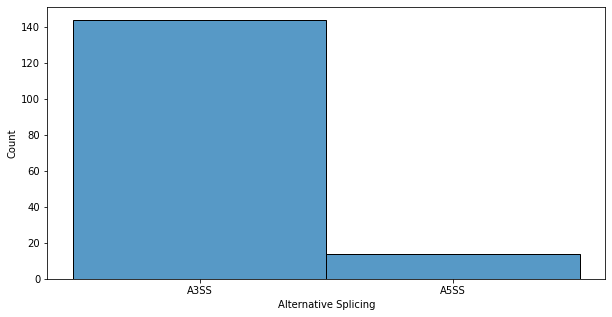

In [19]:
filter_table=table[table["category"].isin(["novel_3p","novel_5p"])]
filter_table["category"]=filter_table["category"].str.replace("novel_3p","A3SS").str.replace("novel_5p","A5SS")
filter_table.rename(columns={"category":"Alternative Splicing"},inplace=True)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.histplot(data=filter_table["Alternative Splicing"])

In [18]:
nmd=all_intron[all_intron["annotation"]=="nonsense_mediated_decay"]

X=nmd.merge(protein_intron,how="inner",on="transcript_id")

In [35]:
from Bio import SeqIO

# Specify the path to your FASTA file
known_protein = "/home/ls/rachelcw/projects/BIO/mutated/mutated_cll_sf3b1_proteomics_known_protein.txt"
novel_protein = "/home/ls/rachelcw/projects/BIO/mutated/mutated_cll_sf3b1_proteomics_novel_protein.txt"

# Read the sequences from the FASTA file
known_sequences = []
for record in SeqIO.parse(known_protein, "fasta"):
    sequence_id = record.id
    sequence = record.seq
    known_sequences.append((sequence_id, sequence))

novel_sequences = []
for record in SeqIO.parse(novel_protein, "fasta"):
    sequence_id = record.id
    sequence = record.seq
    novel_sequences.append((sequence_id, sequence))

# print(known_sequences[0][0])
# print(novel_sequences[0][0])
# print(f"Found {len(sequences)} sequences")


In [36]:
from Bio.pairwise2 import align

def calculate_identity(seq1, seq2):
    alignments = align.globalxx(seq1, seq2)
    # print(alignments)
    top_alignment = alignments[0]
    alignment_length = top_alignment[4]
    matches = top_alignment[2]
    identity = (matches / alignment_length) * 100
    return np.round(identity,3)

# Example protein sequences
results=pd.DataFrame(columns=["known_id","novel_id","known_seq","novel_seq","identity"])

for known in known_sequences:
    for novel in novel_sequences:
        if novel[0].startswith(known[0]):
            identity = calculate_identity(known[1], novel[1])
            results=results.append({"known_id":known[0],"novel_id":novel[0],"known_seq":str(known[1]),"novel_seq":str(novel[1]),"identity":identity},ignore_index=True)


In [7]:
# len(results[results["identity"]==100])/len(results)
identity=results[results["identity"]==100]

In [8]:
identity["junction"]=identity["novel_id"].str.rsplit("|",2,expand=True)[1]
identity["transcript_id"]=identity["novel_id"].str.split("|",2,expand=True)[1]

/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ls/rachelcw/miniconda3/envs/bio/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
with open("/home/ls/rachelcw/projects/BIO/proteomics/100_cases.txt",'w') as file:
    for index, row in identity.iterrows():
        file.write(row["transcript_id"]+'\n')
        file.write(row["junction"]+'\n')
        file.write(f'{transcript_strand_cds[row["transcript_id"]][2][-1]}\n')


**********************************************************************************************************

In [60]:
import pyfaidx as fa
fasta =fa.Fasta("/private1/private/resources/Homo_sapiens_assembly19.fasta")
s=fasta["11"][289920-1:290075].seq
# s1=fasta["11"][290919:291113].seq
print(s)
# print(s1)
# print(len(s))
# print(s1[0:100])




TGTTTCACGACACGCTGCACGTGAGCGGCGTGTACAATGGGGCTGGCGGGGACACGCACCGGGCCATGCTGCCCAGCCCCCTCAACGTCCGGCTGGAGGCCCCTGCAGGGATGGGGGAGCAGCTGACCGAGACCTTCGCCCTGGACACCAACACAG


In [112]:
# genome.exon_ids_of_transcript_id("ENST00000368644.1")
# genome.coding_sequence("ENST00000368644.1")

genome.transcript_by_id("ENST00000393609.3").coding_sequence_position_ranges

[(72437665, 72438173),
 (72425197, 72425366),
 (72424221, 72424288),
 (72423483, 72423613),
 (72423241, 72423384),
 (72422475, 72422544),
 (72422066, 72422186),
 (72421430, 72421632),
 (72420915, 72421021),
 (72418220, 72418419),
 (72416850, 72416935),
 (72415197, 72415379),
 (72413950, 72414124),
 (72412694, 72412828),
 (72410462, 72410597),
 (72410050, 72410152),
 (72408956, 72409151),
 (72408643, 72408694),
 (72408368, 72408531),
 (72408028, 72408240),
 (72407594, 72407699),
 (72406763, 72406910),
 (72406587, 72406673),
 (72406432, 72406500),
 (72406025, 72406142),
 (72404737, 72404850),
 (72404370, 72404515),
 (72403798, 72403830),
 (72399500, 72399582),
 (72398733, 72398783),
 (72398484, 72398547),
 (72397087, 72397236),
 (72396712, 72396726)]

In [29]:
t=genome.transcript_sequence(transcript_id='ENST00000393605.3')

In [57]:
import collections
transcript=collections.namedtuple("transcript",['chr', 'start', 'end','strand','gene_id'])
transcript=transcript(11,1,2,'-','ENSG')
d={"intron1":[{"ENST":transcript}]}
d["intron1"].append({"ENST1":[transcript._make([11,1,2,'-','ENSG2'])]})
d["intron1"]["ENST1"].append(transcript._make([12,1,2,'-','ENSG2']))
d["intron2"]={"ENST2":transcript._make([11,1,2,'-','ENSG2'])}
print(d)
for i in d.keys():
    print(i)
    for j in d[i].keys():
        print(j)

TypeError: list indices must be integers or slices, not str

In [ ]:
# # option to frame shift- need to change the modulo to the len of the gene until the new locus # #
# start_novel_intron=novel_intron[novel_intron["novel"]=="start"]
# # start_novel_intron["frameshift"]=0
# for index, row in start_novel_intron.iterrows():
#     transcript=row["transcript_id"].split(",")
#     t_frame=[]
#     for t in transcript:
#         start_exon=np.array([l[1] for l in transcript_exons[t]])
#         print(row["end"])
#         print(start_exon)
#         index_exon=np.abs(start_exon-row["end"]).argmin()
#         print(index_exon)
#         print("old",transcript_exons[t][index_exon])
#         new_exon_locus=tuple([transcript_exons[t][index_exon][0],row["end"],transcript_exons[t][index_exon][2],transcript_exons[t][index_exon][3]])
#         transcript_exons_updated[t][index_exon]=new_exon_locus
#         if (transcript_exons[t][index_exon][2]-transcript_exons[t][index_exon][1]-1)%3!=0:
#             print("new",new_exon_locus)
#             t_frame.append(t)
#     start_novel_intron.loc[index,"frameshift"]=','.join(t_frame)
        
        


In [57]:
# # my tryint to create a dictionary of {intron(junction):{t_is:[exons locus]}} ##

# intron_transcript=dict()
# for index, row in novel_intron.iterrows():
#     transcript=row["transcript_id"].split(",")
#     intron_transcript[row["intron"]] = [{t: transcript_exons[t]} for t in transcript]

# start_novel_intron=novel_intron[novel_intron["novel"]=="start"]
# # start_novel_intron["frameshift"]=0
# for index, row in start_novel_intron.iterrows():
#     transcript=row["transcript_id"].split(",")
#     for i,t in enumerate(transcript):
#         start_exon=np.array([l[1] for l in transcript_exons[t]])
#         index_exon=np.argmax(start_exon>row["end"])
#         if row["start"]==transcript_exons[t][index_exon][2]:
#             index_exon=index_exon+1
#         new_exon_locus=tuple([transcript_exons[t][index_exon][0],row["end"],transcript_exons[t][index_exon][2],transcript_exons[t][index_exon][3]])
#         # print(intron_transcript[row["intron"]][i][t][index_exon])
#         intron_transcript[row["intron"]][i][t][index_exon]=new_exon_locus
#         # print(intron_transcript[row["intron"]][i][t][index_exon])
#         # print(t)
#         # print(row["end"])
#         # print(start_exon)
#         # print(index_exon)
#         # print("old",transcript_exons[t][index_exon])
#         # print(transcript_exons[t])
#         # print("new",new_exon_locus)
           
# end_novel_intron=novel_intron[novel_intron["novel"]=="end"]
# # start_novel_intron["frameshift"]=0
# for index, row in end_novel_intron.iterrows():
#     transcript=row["transcript_id"].split(",")
#     # t_frame=[]
#     for i,t in enumerate(transcript):
#         end_exon=np.array([l[2] for l in transcript_exons[t]])
#         index_exon=np.argmin(end_exon<row["start"])
#         if row["end"]==transcript_exons[t][index_exon][1]:
#             index_exon=index_exon-1
#         new_exon_locus=tuple([transcript_exons[t][index_exon][0],transcript_exons[t][index_exon][1],row["start"],transcript_exons[t][index_exon][3]])
#         intron_transcript[row["intron"]][i][t][index_exon]=new_exon_locus
#         # print(end_exon<row["start"])
#         # print(t)
#         # print(row["start"])
#         # print(end_exon)
#         # print(index_exon)
#         # print("old",transcript_exons[t][index_exon])
#         # print(transcript_exons[t])
#         # print("new",new_exon_locus)

# novel_novel_intron=novel_intron[novel_intron["novel"]=="novel"]
# # start_novel_intron["frameshift"]=0
# for index, row in novel_novel_intron.iterrows():
#     transcript=row["transcript_id"].split(",")
#     # t_frame=[]
#     for i,t in enumerate(transcript):
#         start_exon=np.array([l[1] for l in transcript_exons[t]])
#         end_exon=np.array([l[2] for l in transcript_exons[t]])
#         index_start=np.argmax(start_exon>row["end"])
#         if row["start"]==transcript_exons[t][index_start][2]:
#             index_start=index_start+1
#         index_end=np.argmin(end_exon<row["start"])
#         if row["end"]==transcript_exons[t][index_end][1]:
#             index_end=index_end-1
#         new_start=tuple([transcript_exons[t][index_start][0],row["end"],transcript_exons[t][index_start][2],transcript_exons[t][index_start][3]])
#         new_end=tuple([transcript_exons[t][index_end][0],transcript_exons[t][index_end][1],row["start"],transcript_exons[t][index_end][3]])
#         intron_transcript[row["intron"]][i][t][index_start]=new_start
#         intron_transcript[row["intron"]][i][t][index_end]=new_end

In [ ]:
# pyensembl.search.find_nearest_locus(start, end, loci)
# Finds nearest locus (object with method distance_to_interval) to the interval defined by the given start and end positions. Returns the distance to that locus, along with the locus object itself.

In [49]:
non_protein=get_gene_list(novel_intron.loc[novel_intron["transcript_id"]=='',"genes"].unique())

In [60]:
len(novel_intron.iloc[191]["transcript_id"])

0

In [54]:
protein_intron.loc[protein_intron["gene"].isin(non_protein),"gene"].unique()

array(['PLGLB2'], dtype=object)

In [59]:
genome.transcript_ids_at_locus(contig="2",position=88037624)

[]

In [21]:
genome.transcript_ids_of_exon_id('ENSE00000728678.1')

ValueError: No results found for query:

            SELECT distinct transcript_id
            FROM transcript
            WHERE exon_id = ?
        
with parameters: ['ENSE00000728678.1']

In [62]:
genome.transcript_ids_at_locus(contig="10",position=131960844,end=131964771,strand="+")

['ENST00000331244.5', 'ENST00000368644.1', 'ENST00000481034.1']